In [1]:
import torch
import datetime
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import resnet, alexnet, inception_v3
from torchvision.datasets import coco
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [10]:
def compute_mem_size(t):
    t_size = t.size()
    n_nums = 1
    for n in t_size:
        n_nums *= n
    bit_size_map = {torch.float32 : 32, torch.float16 : 16, torch.float64 : 64, torch.uint8 : 8, torch.int8 : 8, torch.int16 : 16, torch.int32 : 32, torch.int64 : 64}
    return (n_nums * bit_size_map[t.dtype]) / 8

In [4]:
BASE = '/Users/ankitmathur/'
ANN_PATH = 'datasets/coco/cocoapi/annotations/instances_val2017.json'
VAL_PATH = 'datasets/coco/cocoapi/images/val2017/'

In [5]:
def merge_coco(l):
    return torch.stack([x[0] for x in l])

## ResNet

In [ ]:
resnet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
])
resnet_dataset = coco.CocoDetection(root=BASE+VAL_PATH, annFile=BASE+ANN_PATH, transform=resnet_transform)
resnet_eval_loader = torch.utils.data.DataLoader(resnet_dataset, batch_size=1, shuffle=True, collate_fn=merge_coco)

In [ ]:
resnet_model = resnet.resnet18(pretrained=True)

In [ ]:
def resnet_measure_forward(model, x):
    print('Image size:', compute_mem_size(x))
    t0 = datetime.datetime.now()
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    t1 = datetime.datetime.now()
    dt1 = t1 - t0
    print('After conv1 (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    t2 = datetime.datetime.now()
    x = model.maxpool(x)
    t3 = datetime.datetime.now()
    dt2 = t3 - t2
    print('After maxpool (' + str(dt2.total_seconds()) + '):', compute_mem_size(x))
    t4 = datetime.datetime.now()
    x = model.layer1(x)
    t5 = datetime.datetime.now()
    dt3 = t5 - t4
    print('After l1 (' + str(dt3.total_seconds()) + '):', compute_mem_size(x))
    t6 = datetime.datetime.now()
    x = model.layer2(x)
    t7 = datetime.datetime.now()
    dt4 = t7 - t6
    print('After l2 (' + str(dt4.total_seconds()) + '):', compute_mem_size(x))
    t8 = datetime.datetime.now()
    x = model.layer3(x)
    t9 = datetime.datetime.now()
    dt5 = t9 - t8
    print('After l3 (' + str(dt5.total_seconds()) + '):', compute_mem_size(x))
    t10 = datetime.datetime.now()
    x = model.layer4(x)
    t11 = datetime.datetime.now()
    dt6 = t11 - t10
    print('After l4 (' + str(dt6.total_seconds()) + '):', compute_mem_size(x))
    t12 = datetime.datetime.now()
    x = model.avgpool(x)
    t13 = datetime.datetime.now()
    dt7 = t13 - t12
    print('After avgpool (' + str(dt7.total_seconds()) + '):', compute_mem_size(x))
    x = x.view(x.size(0), -1)
    t14 = datetime.datetime.now()
    x = model.fc(x)
    t15 = datetime.datetime.now()
    dt8 = t15 - t14
    print('After fc (' + str(dt8.total_seconds()) + '):', compute_mem_size(x))
    return x

In [ ]:
resnet_model.eval()
for batch in resnet_eval_loader:
    resnet_measure_forward(resnet_model, batch)
    break

## AlexNet

In [ ]:
alexnet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
])
alexnet_dataset = coco.CocoDetection(root=BASE+VAL_PATH, annFile=BASE+ANN_PATH, transform=resnet_transform)
alexnet_eval_loader = torch.utils.data.DataLoader(alexnet_dataset, batch_size=1, shuffle=True, collate_fn=merge_coco)

In [ ]:
alexnet_model = alexnet(pretrained=True)

In [ ]:
def alexnet_measure_forward(model, x):
    print('Image size: ', compute_mem_size(x))
    for module in model.features:
        t1 = datetime.datetime.now()
        x = module(x)
        t2 = datetime.datetime.now()
        dt1 = t2 - t1
        canon_name = type(module).__name__
        print('After ' + canon_name + '(' + str(dt1.total_seconds()) + '):  ' + str(compute_mem_size(x)))
    # resize step.
    x = x.view(x.size(0), 256 * 6 * 6)
    # classification step
    for module in model.classifier:
        t1 = datetime.datetime.now()
        x = module(x)
        t2 = datetime.datetime.now()
        dt1 = t2 - t1
        canon_name = type(module).__name__
        print('After ' + canon_name + '(' + str(dt1.total_seconds()) + '):  ' + str(compute_mem_size(x)))

In [ ]:
alexnet_model.eval()
for batch in alexnet_eval_loader:
    alexnet_measure_forward(alexnet_model, batch)
    break

## Inception V3

In [6]:
inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
])
inception_dataset = coco.CocoDetection(root=BASE+VAL_PATH, annFile=BASE+ANN_PATH, transform=inception_transform)
inception_eval_loader = torch.utils.data.DataLoader(inception_dataset, batch_size=1, shuffle=True, collate_fn=merge_coco)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [7]:
inception_model = inception_v3(pretrained=True)

In [24]:
# incomplete
def inception_measure_forward(model, x):
    print('Image size: ', compute_mem_size(x))
    # 299 x 299 x 3
    t1 = datetime.datetime.now()
    x = model.Conv2d_1a_3x3(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Conv2d1a (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 149 x 149 x 32
    t1 = datetime.datetime.now()
    x = model.Conv2d_2a_3x3(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Conv2d2a (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 147 x 147 x 32
    t1 = datetime.datetime.now()
    x = model.Conv2d_2b_3x3(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Conv2d2b (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 147 x 147 x 64
    t1 = datetime.datetime.now()
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After MaxPool2d (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 73 x 73 x 64
    t1 = datetime.datetime.now()
    x = model.Conv2d_3b_1x1(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Conv2d3B (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 73 x 73 x 80
    t1 = datetime.datetime.now()
    x = model.Conv2d_4a_3x3(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Conv2d4A (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 71 x 71 x 192
    t1 = datetime.datetime.now()
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    plt.hist(x.view(-1).data.numpy(), bins=15)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After MaxPool2D (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 35 x 35 x 192
    t1 = datetime.datetime.now()
    x = model.Mixed_5b(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed5B (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 35 x 35 x 256
    t1 = datetime.datetime.now()
    x = model.Mixed_5c(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed5C (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 35 x 35 x 288
    t1 = datetime.datetime.now()
    x = model.Mixed_5d(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed5D (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 35 x 35 x 288
    t1 = datetime.datetime.now()
    x = model.Mixed_6a(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed6A (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 17 x 17 x 768
    t1 = datetime.datetime.now()
    x = model.Mixed_6b(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed6B (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 17 x 17 x 768
    t1 = datetime.datetime.now()
    x = model.Mixed_6c(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed6C (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 17 x 17 x 768
    t1 = datetime.datetime.now()
    x = model.Mixed_6d(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed6D (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 17 x 17 x 768
    t1 = datetime.datetime.now()
    x = model.Mixed_6e(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed6E (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 17 x 17 x 768
    t1 = datetime.datetime.now()
    x = model.Mixed_7a(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed7A (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 8 x 8 x 1280
    t1 = datetime.datetime.now()
    x = model.Mixed_7b(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed7B (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 8 x 8 x 2048
    t1 = datetime.datetime.now()
    x = model.Mixed_7c(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After Mixed7C (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 8 x 8 x 2048
    t1 = datetime.datetime.now()
    x = F.avg_pool2d(x, kernel_size=8)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After AvgPool2d (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 1 x 1 x 2048
    x = F.dropout(x, training=model.training)
    # 1 x 1 x 2048
    x = x.view(x.size(0), -1)
    # 2048
    t1 = datetime.datetime.now()
    x = model.fc(x)
    t2 = datetime.datetime.now()
    dt1 = t2 - t1
    print('After FC (' + str(dt1.total_seconds()) + '):', compute_mem_size(x))
    # 1000 (num_classes)
    return x

Image size:  1072812.0
After Conv2d1a (0.004124): 2841728.0
After Conv2d2a (0.010699): 2765952.0
After Conv2d2b (0.020572): 5531904.0
After MaxPool2d (0.014877): 1364224.0
After Conv2d3B (0.00457): 1705280.0
After Conv2d4A (0.029353): 3871488.0
After MaxPool2D (0.439989): 940800.0
After Mixed5B (0.026572): 1254400.0
After Mixed5C (0.03094): 1411200.0
After Mixed5D (0.030154): 1411200.0
After Mixed6A (0.018021): 887808.0
After Mixed6B (0.02706): 887808.0
After Mixed6C (0.0294): 887808.0
After Mixed6D (0.033287): 887808.0
After Mixed6E (0.040299): 887808.0
After Mixed7A (0.016253): 327680.0
After Mixed7B (0.02211): 524288.0
After Mixed7C (0.027271): 524288.0
After AvgPool2d (0.000297): 8192.0
After FC (0.000746): 4000.0


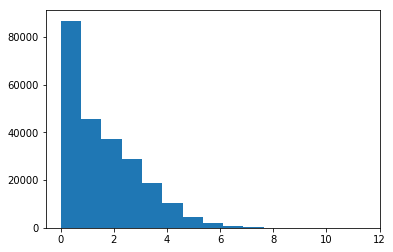

In [26]:
inception_model.eval()
for batch in inception_eval_loader:
    inception_measure_forward(inception_model, batch)
    plt.show()
    break

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
imagenet_data = ImageFolder('val/', transforms.Compose([
        transforms.Resize((299, 299)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize]))
data_loader = torch.utils.data.DataLoader(
    imagenet_data,
    batch_size=1,
    shuffle=False)

In [16]:
inception_model.eval()
correct = 0
total = 0
for batch in data_loader:
    data, label = batch
    result = inception_model(data)
    if (torch.argmax(result) == label[0]):
        correct += 1
    total += 1
    print(total)
    if total > 200:
        break
print('Test accuracy:', (float(correct) / total) * 100)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
Test accuracy: 22.885572139303484


In [19]:
import matplotlib.pyplot as plt

In [20]:
plt.show()

(array([1., 0., 0., 0., 1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. ]),
 <a list of 5 Patch objects>)

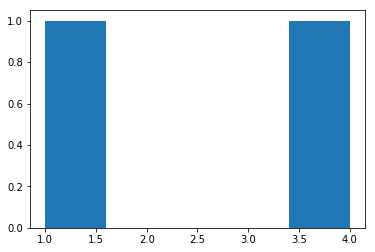

In [23]:
plt.hist([1,4], bins=5)